### 라이브러리 불러오기

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'Malgun Gothic'

## 리뷰 심층분석 시작(문제정의를 위한, 심화 EDA)

In [2]:
# 데이터 로드
master_orders = pd.read_csv('../data/master/master_orders.csv')

In [3]:
# 1. 리뷰 분포
master_orders['review_score'].value_counts(normalize=True)

review_score
5.0    0.591489
4.0    0.197145
1.0    0.097921
3.0    0.082939
2.0    0.030505
Name: proportion, dtype: float64

In [4]:
# 2. 지연 vs 리뷰
master_orders.groupby('is_delayed')['review_score'].mean()

is_delayed
0    4.293529
1    2.563000
Name: review_score, dtype: float64

In [5]:
# 기술 통계
print(master_orders['review_score'].describe())

count    94443.000000
mean         4.153775
std          1.286123
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


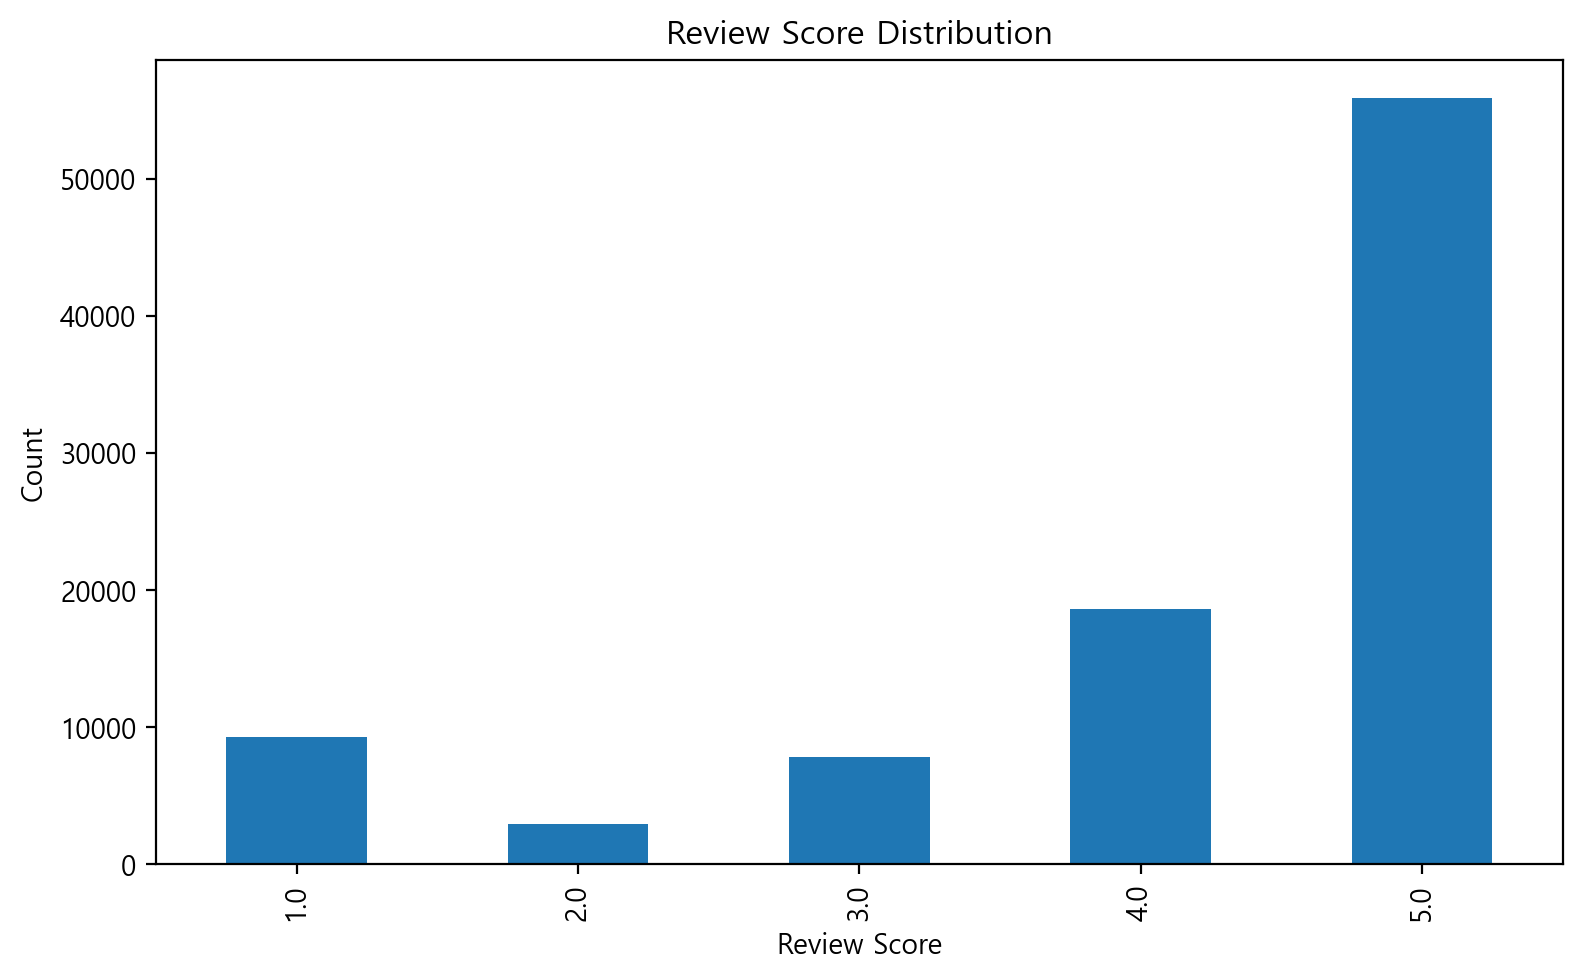

In [6]:
import matplotlib.pyplot as plt

# 리뷰 분포 막대그래프
fig, ax = plt.subplots(figsize=(8, 5))
master_orders['review_score'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
ax.set_title('Review Score Distribution')
plt.tight_layout()
plt.show()

In [7]:
# 양극화 지수 (5점 + 1점 비율)
score_dist = master_orders['review_score'].value_counts(normalize=True)
five_star = score_dist.get(5, 0) * 100
one_star = score_dist.get(1, 0) * 100
polarization = five_star + one_star

print(f"5점 비율: {five_star:.1f}%")
print(f"1점 비율: {one_star:.1f}%")
print(f"양극화 지수: {polarization:.1f}%")

5점 비율: 59.1%
1점 비율: 9.8%
양극화 지수: 68.9%


In [8]:
# 리뷰_제목 Join을 위함
order_reviews = pd.read_csv('../data/processed_v2/olist_order_reviews_dataset.csv')

In [9]:
# 1점 리뷰 + 텍스트 정보 조인
one_star_orders = master_orders[master_orders['review_score'] == 1][['order_id']]

one_star_with_text = one_star_orders.merge(
    order_reviews[['order_id', 'review_comment_title', 'review_comment_message']],
    on='order_id',
    how='left'
)

print(f"1점 리뷰: {len(one_star_with_text):,}건")
print(f"title 있음: {one_star_with_text['review_comment_title'].notna().sum():,}건")
print(f"message 있음: {one_star_with_text['review_comment_message'].notna().sum():,}건")

1점 리뷰: 9,248건
title 있음: 1,549건
message 있음: 7,169건


In [10]:
order_reviews.info()

<class 'pandas.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   review_id                98673 non-null  str  
 1   order_id                 98673 non-null  str  
 2   review_score             98673 non-null  int64
 3   review_comment_title     11552 non-null  str  
 4   review_comment_message   40774 non-null  str  
 5   review_creation_date     98673 non-null  str  
 6   review_answer_timestamp  98673 non-null  str  
dtypes: int64(1), str(6)
memory usage: 5.3 MB


In [11]:
# 점수별 텍스트 현황
review_with_text = master_orders[['order_id', 'review_score']].merge(
    order_reviews[['order_id', 'review_comment_title', 'review_comment_message']],
    on='order_id',
    how='left'
)

text_stats = review_with_text.groupby('review_score').agg(
    total=('order_id', 'count'),
    title_exists=('review_comment_title', lambda x: x.notna().sum()),
    message_exists=('review_comment_message', lambda x: x.notna().sum())
)

text_stats['title_rate'] = (text_stats['title_exists'] / text_stats['total'] * 100).round(1)
text_stats['message_rate'] = (text_stats['message_exists'] / text_stats['total'] * 100).round(1)

print(text_stats)

              total  title_exists  message_exists  title_rate  message_rate
review_score                                                               
1.0            9248          1549            7169        16.7          77.5
2.0            2881           420            1952        14.6          67.8
3.0            7833           770            3389         9.8          43.3
4.0           18619          1656            5804         8.9          31.2
5.0           55862          6369           20044        11.4          35.9


In [ ]:
from deep_translator import GoogleTranslator # googletrans 대신 사용
import time
import pandas as pd
import os

# 1. 경로 및 설정
save_dir = '../data/review_ko'
save_path = os.path.join(save_dir, 'one_star_reviews_translated.csv')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 2. 전체 대상 데이터 준비
full_target_df = review_with_text[
    (review_with_text['review_score'] == 1) & 
    (review_with_text['review_comment_message'].notna())
][['order_id', 'review_comment_title', 'review_comment_message']].copy()

# 3. 이전에 작업하던 파일이 있는지 확인
if os.path.exists(save_path):
    translated_df = pd.read_csv(save_path)
    done_ids = set(translated_df['order_id'].unique())
    print(f"기존 작업 파일을 찾았습니다. 완료된 건수: {len(done_ids):,}건")
else:
    translated_df = pd.DataFrame()
    done_ids = set()
    print("새로운 번역 작업을 시작합니다.")

# 4. 아직 번역 안 된 데이터만 필터링
to_do_df = full_target_df[~full_target_df['order_id'].isin(done_ids)].copy()
print(f"남은 번역 대상: {len(to_do_df):,}건 / 전체: {len(full_target_df):,}건")

# 5. 번역 로직 (deep-translator 적용)
# source='auto'로 두면 포르투갈어를 자동으로 감지합니다. 명시하려면 'pt'를 쓰면 됩니다.
translator = GoogleTranslator(source='pt', target='ko') 
new_results = []

try:
    for i, row in to_do_df.iterrows():
        try:
            curr_msg = None
            curr_title = None

            # 메세지 번역 (deep-translator는 결과가 바로 텍스트로 나옵니다)
            curr_msg = translator.translate(row['review_comment_message'])
            
            # 제목 번역
            if pd.notna(row['review_comment_title']) and str(row['review_comment_title']).strip() != "":
                curr_title = translator.translate(str(row['review_comment_title']))
            
            # 결과 임시 저장
            new_results.append({
                'order_id': row['order_id'],
                'review_comment_title': row['review_comment_title'],
                'review_comment_message': row['review_comment_message'],
                'message_ko': curr_msg,
                'title_ko': curr_title
            })

            if len(new_results) % 50 == 0:
                print(f"현재 세션 진행: {len(new_results)}건 완료 (남은 데이터: {len(to_do_df) - len(new_results)}건)")
                
                # 중간 저장 (선택 사항: 주석 해제 시 50건마다 저장)
                # pd.concat([translated_df, pd.DataFrame(new_results)], ignore_index=True).to_csv(save_path, index=False, encoding='utf-8-sig')

            time.sleep(0.5) # deep-translator는 속도가 조금 더 빨라도 안정적입니다.

        except Exception as e:
            print(f"\n작업 중 에러 발생: {e}")
            break

except KeyboardInterrupt:
    print("\n사용자에 의해 중단되었습니다.")

# 6. 결과 병합 및 최종 저장
if new_results:
    new_df = pd.DataFrame(new_results)
    final_df = pd.concat([translated_df, new_df], ignore_index=True)
    final_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"\n업데이트 완료! 현재 총 {len(final_df):,}건 저장됨.")
else:
    print("\n새로 추가된 번역 내용이 없습니다.")

기존 작업 파일을 찾았습니다. 완료된 건수: 1,162건
남은 번역 대상: 6,007건 / 전체: 7,169건
현재 세션 진행: 50건 완료 (남은 데이터: 5957건)
현재 세션 진행: 100건 완료 (남은 데이터: 5907건)
현재 세션 진행: 150건 완료 (남은 데이터: 5857건)

작업 중 에러 발생: HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=ko&sl=pt&q=N%C3%A3o+Recomendo (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))

업데이트 완료! 현재 총 1,333건 저장됨.


In [ ]:
from deep_translator import GoogleTranslator
import time
import pandas as pd
import os
import random # 불규칙한 대기 시간을 위해 추가

# 1. 경로 및 설정
save_dir = '../data/review_ko'
save_path = os.path.join(save_dir, 'one_star_reviews_translated.csv')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 2. 데이터 준비 (이전과 동일)
full_target_df = review_with_text[
    (review_with_text['review_score'] == 1) & 
    (review_with_text['review_comment_message'].notna())
][['order_id', 'review_comment_title', 'review_comment_message']].copy()

# 3. 작업 이력 로드 및 중복 제거
if os.path.exists(save_path):
    translated_df = pd.read_csv(save_path)
    done_ids = set(translated_df['order_id'].unique())
    print(f"기존 작업 파일을 찾았습니다. 완료된 건수: {len(done_ids):,}건")
else:
    translated_df = pd.DataFrame()
    done_ids = set()
    print("새로운 번역 작업을 시작합니다.")

to_do_df = full_target_df[~full_target_df['order_id'].isin(done_ids)].copy()
print(f"남은 번역 대상: {len(to_do_df):,}건 / 전체: {len(full_target_df):,}건")

# 4. 번역 로직 (재시도 기능 강화)
translator = GoogleTranslator(source='pt', target='ko')
new_results = []

# 안전한 번역을 위한 헬퍼 함수
def translate_safe(text, translator, max_retries=5):
    for attempt in range(max_retries):
        try:
            return translator.translate(text)
        except Exception as e:
            wait_time = (attempt + 1) * 20 # 에러 시 대기 시간 점진적 증가 (20초, 40초...)
            print(f"\n[에러 발생] {e}")
            print(f"[{attempt+1}/{max_retries}] {wait_time}초 후 다시 시도합니다...")
            time.sleep(wait_time)
    return None # 끝까지 실패하면 None 반환

try:
    for i, row in to_do_df.iterrows():
        try:
            # 메세지 번역
            curr_msg = translate_safe(row['review_comment_message'], translator)
            if curr_msg is None: # 계속 실패하면 이 데이터는 건너뜀
                continue
                
            # 제목 번역
            curr_title = None
            if pd.notna(row['review_comment_title']) and str(row['review_comment_title']).strip() != "":
                curr_title = translate_safe(str(row['review_comment_title']), translator)
            
            # 결과 저장
            new_results.append({
                'order_id': row['order_id'],
                'review_comment_title': row['review_comment_title'],
                'review_comment_message': row['review_comment_message'],
                'message_ko': curr_msg,
                'title_ko': curr_title
            })

            # 진행률 표시 및 30건마다 파일에 강제 저장 (매우 중요)
            if len(new_results) % 30 == 0:
                print(f"세션 진행: {len(new_results)}건 완료 (남은: {len(to_do_df) - len(new_results)}건)")
                
                # 중간 저장: 에러로 죽더라도 파일은 남도록 함
                temp_df = pd.concat([translated_df, pd.DataFrame(new_results)], ignore_index=True)
                temp_df.to_csv(save_path, index=False, encoding='utf-8-sig')

            # 기본 대기 시간 (랜덤으로 섞어서 봇 감지를 더 잘 피함)
            time.sleep(random.uniform(0.8, 1.5))

        except Exception as e:
            print(f"\n루프 내부 예상치 못한 에러: {e}")
            time.sleep(60) # 심각한 에러 시 1분 대기 후 다음 항목 시도
            continue

except KeyboardInterrupt:
    print("\n사용자에 의해 중단되었습니다.")

# 5. 최종 결과 병합 및 저장
if new_results:
    new_df = pd.DataFrame(new_results)
    final_df = pd.concat([translated_df, new_df], ignore_index=True)
    final_df.drop_duplicates(subset=['order_id'], keep='last', inplace=True) # 중복 방지
    final_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"\n최종 업데이트 완료! 총 {len(final_df):,}건 저장됨.")
else:
    print("\n새로 추가된 내용이 없습니다.")

기존 작업 파일을 찾았습니다. 완료된 건수: 1,333건
남은 번역 대상: 5,836건 / 전체: 7,169건
세션 진행: 30건 완료 (남은: 5806건)
세션 진행: 60건 완료 (남은: 5776건)
세션 진행: 90건 완료 (남은: 5746건)
세션 진행: 120건 완료 (남은: 5716건)

[에러 발생] Comprei um jogo de latas e recebi MARMITAS! --> No translation was found using the current translator. Try another translator?
[1/5] 20초 후 다시 시도합니다...
세션 진행: 150건 완료 (남은: 5686건)

[에러 발생] HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=ko&sl=pt&q=Demorou+para+chegar+e+n%C3%A3o+veio+o+produto+que+comprei.+Produto+mau+embalado%2C+Produto+errado+e+NF+dentro+do+produto+em+nome+de+outra+pessoa.+P%C3%A9ssimo%21+Quero+meu+dinheiro+de+volta%21 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))
[1/5] 20초 후 다시 시도합니다...
세션 진행: 180건 완료 (남은: 5656건)
세션 진행: 210건 완료 (남은: 5626건)
세션 진행: 240건 완료 (남은: 5596건)

[에러 발생] HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?

In [ ]:
import pandas as pd
from transformers import pipeline

# 1. 모델 로드 (GPU가 있다면 device=0 추가)
pipe = pipeline("translation", model="facebook/mbart-large-50-many-to-many-mmt", device=-1)

# 2. 데이터 준비 (이전과 동일)
full_target_df = review_with_text[
    (review_with_text['review_score'] == 1) & 
    (review_with_text['review_comment_message'].notna())
][['order_id', 'review_comment_title', 'review_comment_message']].copy()

# 3. 번역 함수 정의
def translate_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    # src_lang(포르투갈어) -> tgt_lang(한국어)
    result = pipe(text, src_lang="pt_XX", tgt_lang="ko_KR")
    return result[0]['translation_text']

# 4. 컬럼 전체 번역 적용 (예: 'pt_column'을 번역해서 'ko_result' 생성)
# 데이터가 많다면 시간이 걸릴 수 있습니다.
df['ko_result'] = full_target_df['review_comment_message'].apply(translate_text)

# 5. CSV로 저장
df.to_csv('../data/review_ko/translated_result.csv', index=False, encoding='utf-8-sig')
print("번역 및 저장 완료!")
